In [1]:

# Sys imports
import json
import os
import sys
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "jax"

# Training API
import keras as keras
from keras import layers
import keras_nlp

# Data manipulation and exploration
import numpy as np
from scipy.stats import shapiro, kurtosis

# Data visualization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import jax.numpy as jnp

# MLOps API
import mlflow
mlflow.set_tracking_uri('http://localhost:5000')


2024-03-21 13:53:12.448983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 13:53:12.449025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 13:53:12.450149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 13:53:13.067825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# EDA

## Data loading
There are 72M titles and views in the data used.

In [2]:
# DATA LOADER 
def parse_jsonl_optimized(filepath, num_lines_to_import=None):
    titles = []
    view_counts = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for i, line in enumerate(tqdm(file, desc="Processing")):
            # Check if the specified number of lines has been reached (if specified)
            if (num_lines_to_import is not None and i >= num_lines_to_import):
                break
            # Parse the current line
            data = json.loads(line)
            # Extract and store the title and view count
            titles.append(data['title'])
            view_counts.append(data['view_count'])
    return titles, view_counts

# Example usage: Import only the first 1000 lines from the file
file_path = '/mnt/datassd/train_data.jsonl'
num_lines_to_import = 50000  # You can adjust this number as needed
titles, view_counts = parse_jsonl_optimized(file_path, num_lines_to_import)

Processing: 50000it [00:00, 581405.25it/s]


## Create $Log_{10}(Data)$ and create tokenizer

When views are analyzed on their own, the MSE loss function does not make a lot of sense, there is a lot of variation in the data.

What's why we take $log_{10}$ to get the order of magnitude of the views ($10^x$).

In [3]:
y_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))

from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor

# Load BERT tokanizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/tmp/ipykernel_48785/2818422132.py:1: RuntimeWarning: divide by zero encountered in log10
  y_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))


Encoding all 70M datapoints takes ~45mins

In [4]:
""" SINGLE THREADED  """
encoded_inputs = [tokenizer.encode(title, add_special_tokens=True) for title in tqdm(titles, total=len(titles), desc="Encoding")]

Encoding: 100%|█| 50000/50000 [00:02<00:00, 23359.64i


In [5]:
#""" SOMEWHAT MULTITHREADED """
#def encode_title(title):
#    return tokenizer.encode(title, add_special_tokens=True)
#with ThreadPoolExecutor() as executor:
#    encoded_inputs = list(tqdm(executor.map(encode_title, titles), total=len(titles), desc="Encoding"))

In the context of title engagement, UPPER CASED titles correlate with engagement, it is important to use a CASED tokenizer.

In [6]:
# Testing cased inputs in tokenization
titulos_raros = [r'IS THIS TOKEN Cased?']
print(tokenizer.tokenize(titulos_raros[0]))
tokenizer.encode(titulos_raros[0], add_special_tokens=True)

['IS', 'T', '##H', '##IS', 'TO', '##KE', '##N', 'Case', '##d', '?']


[101, 19432, 157, 3048, 6258, 16972, 22441, 2249, 9060, 1181, 136, 102]

## Data Normalization tests

First, let's see the distribution of view counts

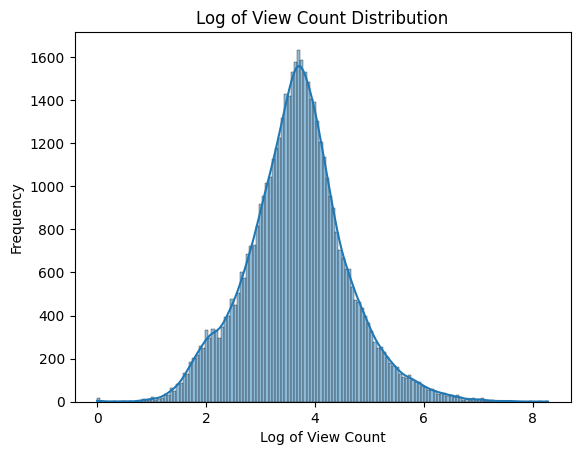

In [7]:
# See Y view count distribution
sns.histplot(y_view_count, kde=True)
plt.title("Log of View Count Distribution")
plt.xlabel("Log of View Count")
plt.ylabel("Frequency")
plt.show()

In [8]:
shapiro_test_stat, shapiro_p_value = shapiro(y_view_count)
kurtosis_value = kurtosis(y_view_count, fisher=True)

shapiro_test_stat, shapiro_p_value, kurtosis_value

/home/jay/.local/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9924662709236145, 5.815388626947991e-43, 0.7361186248336162)

Now let's see the ditribution of lenghts of titles.

We need to have a cutoff at a certain token lenght. So let's visualize when it would be appropriate to cut titles off.

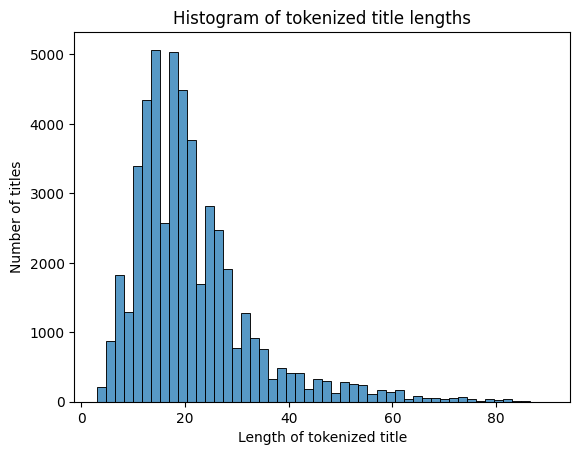

In [9]:
sns.histplot([len(encoded_input) for encoded_input in encoded_inputs], bins=50)
plt.title("Histogram of tokenized title lengths")
plt.xlabel("Length of tokenized title")
plt.ylabel("Number of titles")
plt.show()

Probably at 40 tokens, the cutoff would preserve most of the information. (Remember YouTube titles have a 100 char limit)

In [10]:
max_length = 40  # Ensure your data is adjusted accordingly

padded_inputs = pad_sequences(encoded_inputs, maxlen=max_length, padding='post', truncating='post')


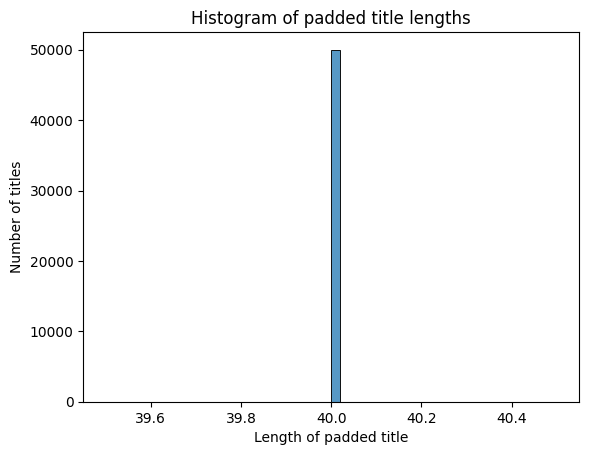

In [11]:
# Just making sure, all inputs are the same length of 40 
sns.histplot([len(padded_input) for padded_input in padded_inputs], bins=50)
plt.title("Histogram of padded title lengths")
plt.xlabel("Length of padded title")
plt.ylabel("Number of titles")
plt.show()

Some samples to see the PADs

In [12]:
sample = [tokenizer.decode(padded_input) for padded_input in padded_inputs[90:100]]
sample

['[CLS] Sigala - Brighter Days ft. Paul Janeway of St. Paul & The Broken Bones [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sigala - What You Waiting For ( Lyrics ) ft. Kylie Minogue [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Sikdope - Lost In The Blue Feat. Nevve [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Smiie - Fool ( Official Music Audio ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Lauv - Superhero ( Moilatch Remix ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [13]:
# Define model architecture
vocab_size = 30522  # Adjusted to match BERT's vocabulary size for bert-base-cased
embedding_dim = 256
num_heads = 4
intermediate_dim = 512
transformer_encoder_layers = 3

X_t = jnp.array(padded_inputs)
Y_t = jnp.array(y_view_count)

inputs = keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size, 
    sequence_length=max_length, 
    embedding_dim=embedding_dim,
)

x = embedding_layer(inputs)

for _ in range(transformer_encoder_layers):
    encoder = keras_nlp.layers.TransformerEncoder(
        num_heads=num_heads,
        intermediate_dim=intermediate_dim,
        activation='relu',
        dropout=0.1,
    )
    x = encoder(x)

x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 40, 256)        │     7,823,872 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 40, 256)        │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,471,233 (36.13 MB)

 Trainable params: 9,471,233 (36.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps


with mlflow.start_run() as run:
    model.fit(X_t, Y_t, batch_size=32, epochs=10, validation_split=0.2, callbacks= [MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)])
mlflow.end_run()

Using JAX backend.


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 1.5685 - mean_squared_error: 1.5685 - val_loss: 0.7068 - val_mean_squared_error: 0.7071
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.8306 - val_mean_squared_error: 0.8314
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.7984 - val_mean_squared_error: 0.7988
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3464 - mean_squared_error: 0.3464 - val_loss: 1.1979 - val_mean_squared_error: 1.1974
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3657 - mean_squared_error: 0.3657 - val_loss: 0.7872 - val_mean_squared_error: 0.7872
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4237 - mean_squared_error: 0.4237 - val_loss: 0.7245 - val_mean_squared_error: 0.7245
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3843 - mean_squared_error: 0.3843 -

# Evaluation

In [15]:
# Load the eval dataset
eval_file_path = '/mnt/datassd/eval_data.jsonl'
titles_eval, view_counts_eval = parse_jsonl_optimized(file_path, 1000)
encoded_evals = [tokenizer.encode(title, add_special_tokens=True) for title in tqdm(titles_eval, total=len(titles_eval), desc="Encoding")]
padded_evals = pad_sequences(encoded_evals, maxlen=max_length, padding='post', truncating='post')
view_evals = np.where(np.log10(view_counts_eval) == -np.inf, 0, np.log10(view_counts_eval))
X_e = jnp.array(padded_evals)
Y_e = jnp.array(view_evals)

Processing: 1000it [00:00, 309451.38it/s]
Encoding: 100%|█| 1000/1000 [00:00<00:00, 14971.80it/


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


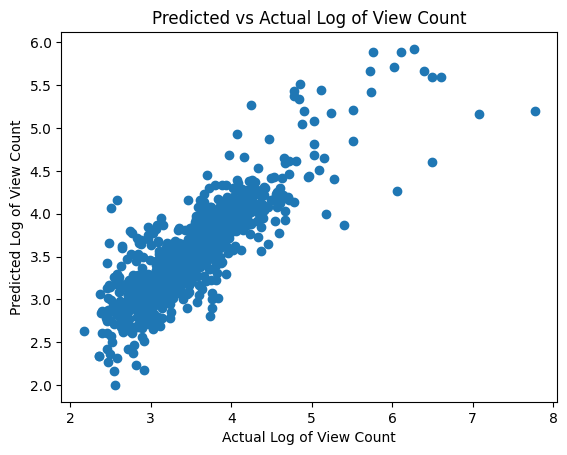

In [16]:
Y_pred = model.predict(X_e)

# Make scatter of predicted vs actual
plt.scatter(Y_e, Y_pred)
# Make a line
plt.plot([0, 10], [0, 10], color='red')
plt.title("Predicted vs Actual Log of View Count")
plt.xlabel("Actual Log of View Count")
plt.ylabel("Predicted Log of View Count")
plt.show()